# Principal components analysis of mutant motility
---

#### Overview
The purpose of this notebook is to analyze the extent to which certain small molecule drugs rescue motility phenotypes in mutant strains of _C. reinhardtii_. The dataset of summary motility statistics that this analysis is based on was generated by running the script, [compute_motility_metrics.py](../src/scripts/compute_motility_metrics.py), as explained in the [README](../README.md).

The analysis is conducted via principal components analysis (PCA) in which PC spaces for wild type and mutant strains are generated on several motility features (such as mean curvilinear speed, mean angular speed, max sprint length, etc.) from cell tracking data of each strain in controls (water and DMSO). The summary motility statistics of mutant strains on drugs are then projected into each respective PC space to determine the extent to which the motility phenotypes of the mutant strains are rescued.

Output from this notebook was used to generate Figures 4 & 6 in the [pub](https://doi.org/10.57844/arcadia-fe2a-711e).

In [1]:
import sys

sys.path.append("../src")

In [2]:
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from stats_testing import joint_grid_with_stats, kde_plot_with_stats

apc.mpl.setup()

#### Define variables
- Define wild-typle vs mutant strains.
- Define controls vs drugs.
- Define which motility metrics to include in the PCA.

In [3]:
# strains
wild_type = "CC-125"
mutant_strains = ["CC-2670", "CC-3707"]

# drugs
controls = ["dmso", "h2o"]
drugs = ["atp", "dyn", "ibu", "lin", "tak", "tor"]

# motility metrics
metrics = [
    "max_sprint_length",
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_linear_speed",
    "mean_angular_speed",
    "pivot_rate",
]

# rename certain variables in the plots
rename_for_plot = {
    "CC-125": "wild type",
    "CC-2670": "ida4 mutant",
    "CC-3707": "cpc1 mutant",
    "max_sprint_length": "Max sprint length",
    "confinement_ratio": "Confinement ratio",
    "mean_curvilinear_speed": "Mean curvilinear speed",
    "mean_linear_speed": "Mean linear speed",
    "mean_angular_speed": "Mean angular speed",
    "pivot_rate": "Pivot rate",
}

# define color palette
color_palette = {
    "wild type": apc.chateau,
    "ida4 mutant": apc.vital,
    "cpc1 mutant": apc.tangerine,
    "wild type + drug": apc.charcoal,
    "ida4 mutant + drug": apc.lapis,
    "cpc1 mutant + drug": apc.dragon,
}

# show color palette
color_palette

{'wild type':    chateau #BAB0A8,
 'ida4 mutant':    vital #73B5E3,
 'cpc1 mutant':    tangerine #FFB984,
 'wild type + drug':    charcoal #484B50,
 'ida4 mutant + drug':    lapis #2B65A1,
 'cpc1 mutant + drug':    dragon #C85152}

#### Load summary motility statistics
Load dataset of summary motility statistics of all strains swimming in both drugs and controls two hours post-treatment.

In [4]:
motility_csv = Path(
    "../data/single-cell-motility-assay/single-cell-motility-assay_summary-statistics.csv"
)
motility_dataframe = pd.read_csv(motility_csv)
motility_dataframe.head()

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,strain,drug,hours_in_drug,concentration,well_ID
0,20.704225,230.867728,147.046824,7.562634,0.636931,11.150754,7.102262,1.526070,2.0,17,0.073635,15,CC-125,tor,2,12.5,WellA01
1,11.901408,382.449800,125.138478,17.248704,0.327202,32.134835,10.514594,2.686931,2.0,21,0.054909,15,CC-125,tor,2,12.5,WellA01
2,20.704225,156.499828,110.772470,7.823802,0.707812,7.558835,5.350235,2.427813,2.0,34,0.217253,15,CC-125,tor,2,12.5,WellA01
3,20.704225,411.206653,164.362285,12.917934,0.399707,19.861002,7.938587,1.467109,1.0,16,0.038910,15,CC-125,tor,2,12.5,WellA01
4,20.704225,154.341462,107.157320,6.164652,0.694287,7.454588,5.175626,2.173751,0.0,26,0.168458,15,CC-125,tor,2,12.5,WellA01


## Construct PCAs
---

#### Build PC spaces on wild-type and mutant motility in controls
Three PC spaces to build:
- Wild type in controls
- Wild type + ida4 mutant in controls
- Wild type + cpc1 mutant in controls

In [5]:
# set number of PCA components
num_components = 2

# build a Dataframe for each mutant strain + wild-type in controls
pcas_controls = {}
motility_dataframes_controls = {}

for strain in [wild_type] + mutant_strains:
    # filter dataframe to only include motility metrics stats in controls
    motility_dataframe_controls = motility_dataframe.loc[
        motility_dataframe["strain"].isin([strain, wild_type])
        & motility_dataframe["drug"].isin(controls)
    ].copy()

    # apply min-max normalization to the data
    metrics_controls = motility_dataframe_controls.loc[:, metrics]
    _min = metrics_controls.min()
    _max = metrics_controls.max()
    metrics_controls_normalized = (metrics_controls - _min) / (_max - _min)

    # create and fit PCA
    pca = PCA(n_components=num_components)
    motility_components = pca.fit_transform(metrics_controls_normalized)

    # add principal components to dataframe
    for i in range(num_components):
        key = f"PC-{i + 1}"
        motility_dataframe_controls[key] = motility_components[:, i]

    motility_dataframes_controls[strain] = motility_dataframe_controls
    pcas_controls[strain] = pca

#### Visualize principal components and compare WT vs each mutant with statistical tests
PC spaces to visualize:
- Wild type + ida4 mutant in controls
- Wild type + cpc1 mutant in controls

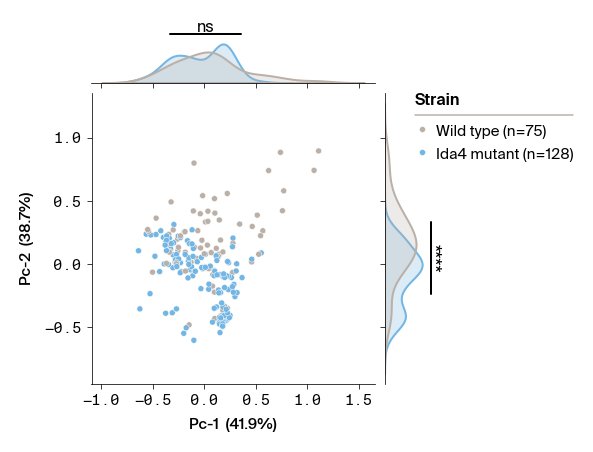

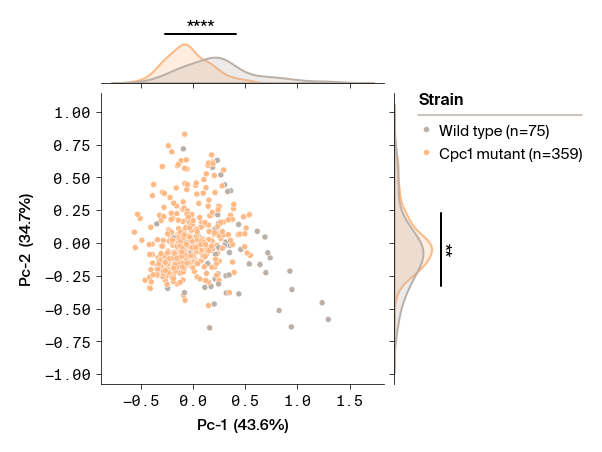

In [6]:
for i, mutant_strain in enumerate(mutant_strains):
    source = motility_dataframes_controls[mutant_strain].copy()
    source["strain"] = source["strain"].map(rename_for_plot)

    # render JointGrid
    joint_grid = joint_grid_with_stats(
        data=source,
        x_variable="PC-1",
        y_variable="PC-2",
        hue_variable="strain",
        palette=color_palette,
    )

    # aesthetics
    variances = pcas_controls[mutant_strain].explained_variance_ratio_
    joint_grid.ax_joint.set_xlabel(f"PC-1  ({variances[0]:.1%})")
    joint_grid.ax_joint.set_ylabel(f"PC-2  ({variances[1]:.1%})")
    sns.move_legend(joint_grid.ax_joint, "upper right", bbox_to_anchor=(1.7, 1))
    apc.mpl.style_plot(joint_grid.ax_joint, monospaced_axes="both")

    # save plots
    panel = ["B", "C"][i]
    filename = f"../results/figure-4{panel}.pdf"
    apc.mpl.save_figure(filename)

#### Visualize the loadings for the mutant + wild type PC spaces

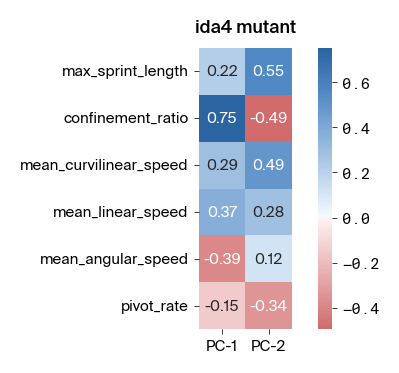

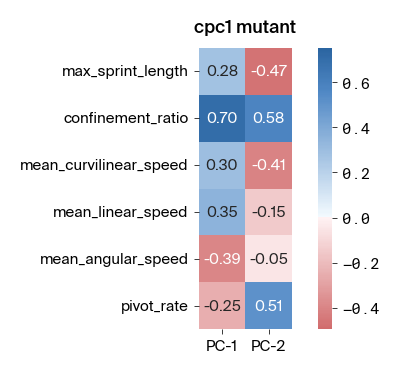

In [7]:
# configure colormap and colorbar range
cmap = apc.gradients.red_blue.to_mpl_cmap()
vmin = np.min([pcas_controls[mutant_strain].components_ for mutant_strain in mutant_strains])
vmax = np.max([pcas_controls[mutant_strain].components_ for mutant_strain in mutant_strains])

for i, mutant_strain in enumerate(mutant_strains):
    # create figure
    figsize = apc.mpl.get_figure_dimensions("float_wide")
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    # create heatmap
    loadings = pcas_controls[mutant_strain].components_.T
    xticklabels = [f"PC-{i + 1}" for i in range(num_components)]
    ax = sns.heatmap(
        loadings,
        cmap=cmap,
        xticklabels=xticklabels,
        yticklabels=metrics,
        annot=True,
        fmt=".2f",
        square=True,
        cbar=True,
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )

    # figure aesthetics
    ax.set_title(rename_for_plot[mutant_strain])
    apc.mpl.style_plot(colorbar_exists=True)

    # save plots
    panel = ["D", "E"][i]
    filename = f"../results/figure-4{panel}.pdf"
    apc.mpl.save_figure(filename)

## PCA projections
---

#### Compute PCA projections from motility data of cells on drugs
Project summary motility statistics from each strain on drugs into the PC-spaces constructed on the wild type and mutants in controls. Three projections:
- Drugged wild type onto PC space of wild type in controls
- Drugged ida4 onto PC space of wild type + ida4 in controls
- Drugged cpc1 onto PC space of wild type + cpc1 in controls

In [8]:
# select drug concentration to filter on
concentration = 50  # µM

# store a Dataframe containing the principal component data
# for each mutant strain + wild type in each drug
motility_dataframes_drugs = {}

for strain in [wild_type] + mutant_strains:
    for drug in drugs:
        # no motility data available for wild type on ibudilast
        if strain == wild_type and drug == "ibu":
            continue

        # create filtered dataframe of motility data from wild type and mutant cells on each drug
        motility_dataframe_drugged_strain = motility_dataframe.loc[
            (motility_dataframe["strain"] == strain)
            & (motility_dataframe["drug"] == drug)
            & (motility_dataframe["concentration"] == concentration)
        ].copy()

        # apply min-max normalization to the data
        metrics_drugged_strain = motility_dataframe_drugged_strain.loc[:, metrics]
        _min = metrics_drugged_strain.min()
        _max = metrics_drugged_strain.max()
        metrics_drugged_strain_normalized = (metrics_drugged_strain - _min) / (_max - _min)

        # project drugged mutant motility into PC space of mutant + wild type in controls
        pca = pcas_controls[strain]
        motility_components = pca.transform(metrics_drugged_strain_normalized)

        # add principal components to dataframe
        for i in range(num_components):
            key = f"PC-{i + 1}"
            motility_dataframe_drugged_strain[key] = motility_components[:, i]

        motility_dataframes_drugs[(strain, drug)] = motility_dataframe_drugged_strain

#### Visualize PCA projections
Generate KDE plots for the first two principal components. For each drug, compare WT + control with mutant + drug and compute statistical significance using Mann-Whitney _U_ test.

Note that the legend text for the figure in the pub was edited manually in Adobe Illustrator.

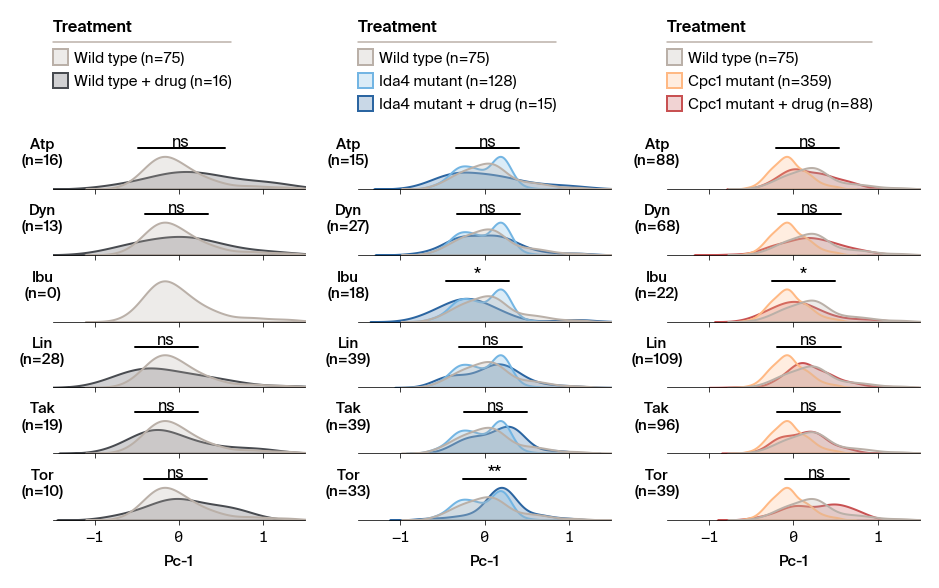

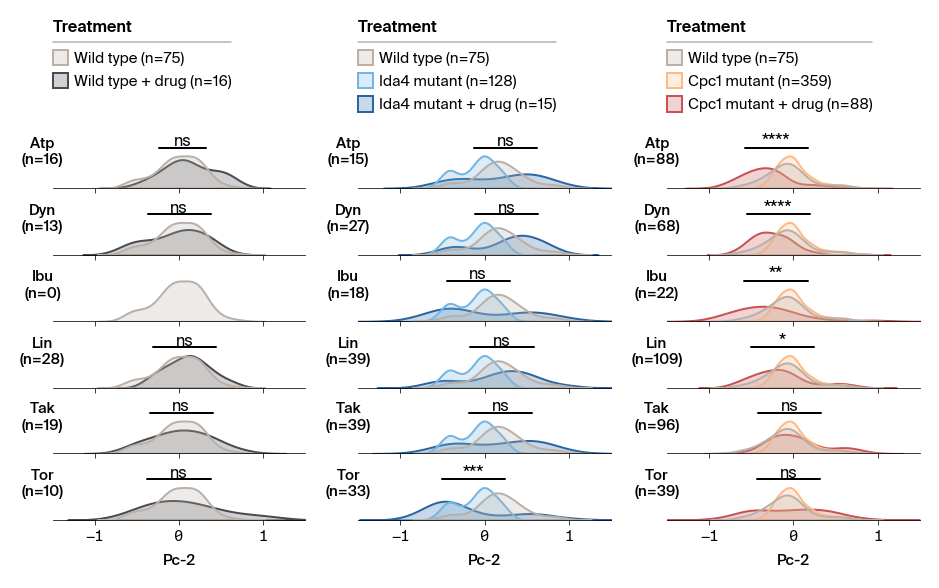

In [9]:
# create figure for each principal component
for pc_i in range(num_components):
    fig_width = apc.mpl.get_figure_dimensions("full_wide")[0]
    fig_height = 0.6 * fig_width
    fig, axes = plt.subplots(
        nrows=len(drugs),
        ncols=3,
        layout="constrained",
        sharex=True,
        figsize=(fig_width, fig_height),
    )

    # left-most axis: wild type in controls vs drugged wild type
    # ----------------------------------------------------------
    for drug_i, drug in enumerate(drugs):
        # configure parameters for plotting
        ax = axes[drug_i, 0]
        legend = False if drug_i > 0 else True
        xlims = (-1.5, 1.5)

        # concatenate motility data from the PC space built on controls + projections
        # from each drug
        source = pd.concat(
            [
                motility_dataframes_controls.get(wild_type),
                motility_dataframes_drugs.get((wild_type, drug)),
            ]
        )
        # create a "treatment" label to jive with the color palette
        treatment = source["drug"].isin(drugs).map({True: "wild type + drug", False: "wild type"})
        source["treatment"] = treatment

        # KDE plots
        if drug != "ibu":  # no motility data available for wild type on ibudilast
            # generate the KDE plot with statistical annotations
            kde_plot = kde_plot_with_stats(
                data=source,
                x_variable=f"PC-{pc_i + 1}",
                hue_variable="treatment",
                common_norm=False,
                palette=color_palette,
                fill=True,
                lw=2,
                legend=legend,
                ax=ax,
            )
        else:  # ibudilast gets a special plot
            # generate a KDE plot sans statistical annotations
            kde_plot = sns.kdeplot(
                data=source,
                x=f"PC-{pc_i + 1}",
                hue="treatment",
                common_norm=False,
                palette=color_palette,
                fill=True,
                lw=2,
                legend=legend,
                ax=ax,
            )

        # aesthetics
        num_drugged_cells = source.query("drug == @drug").shape[0]
        ylabel = f"{drug}\n(n={num_drugged_cells})"
        ax.set_ylabel(ylabel, rotation=0)
        ax.yaxis.set_ticks([])
        ax.set_xlim(xlims)
        sns.despine(ax=ax, left=True)
        if legend:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 4))
        apc.mpl.style_plot(ax, monospaced_axes="both")

    # center and right-most axes: drugged mutant vs mutant and wild type in controls
    # ------------------------------------------------------------------------------
    for mutant_i, mutant_strain in enumerate(mutant_strains):
        for drug_i, drug in enumerate(drugs):
            # configure parameters for plotting
            ax = axes[drug_i, mutant_i + 1]
            legend = False if drug_i > 0 else True

            # concatenate motility data from the PC space built on controls + projections
            # from each drug
            source = pd.concat(
                [
                    motility_dataframes_controls.get(mutant_strain),
                    motility_dataframes_drugs.get((mutant_strain, drug)),
                ]
            )
            # create a "treatment" label to jive with the color palette
            treatment = source["drug"].isin(drugs).map({True: " + drug", False: ""})
            source["treatment"] = source["strain"].map(rename_for_plot) + treatment
            # specify groups for stats testing since there are > 2 "treatments"
            # only want to compare wild type in controls vs mutant + drug
            groups = ["wild type", f"{rename_for_plot[mutant_strain]} + drug"]

            # generate the KDE plot with statistical annotations
            kde_plot = kde_plot_with_stats(
                data=source,
                x_variable=f"PC-{pc_i + 1}",
                hue_variable="treatment",
                groups=groups,
                common_norm=False,
                palette=color_palette,
                fill=True,
                lw=2,
                legend=legend,
                ax=ax,
            )

            # aesthetics
            num_drugged_cells = source.query("drug == @drug").shape[0]
            ylabel = f"{drug}\n(n={num_drugged_cells})"
            ax.set_ylabel(ylabel, rotation=0)
            ax.yaxis.set_ticks([])
            ax.set_xlim(xlims)
            sns.despine(ax=ax, left=True)
            if legend:
                sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 4))
            apc.mpl.style_plot(ax, monospaced_axes="both")

    # save figure
    panels = ["ABC", "DEF"][pc_i]
    filename = f"../results/figure-6{panels}.pdf"
    apc.mpl.save_figure(filename)